# Введение в Data Science
## Эпизод 6: Исчезновение учителя


Авторы теоретического материала - исследователь СколТеха Сергей Королев и программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

Основное отличие методов обучения без учителя от привычных классификаций и регрессий машинного обучения в том, что разметки для данных в этом случае нет. От этого образуются сразу несколько особенностей — во-первых это возможность использования несопоставимо больших объёмов данных, поскольку их не нужно будет размечать руками для обучения, а во-вторых это неясность измерения качества методов, из-за отсутствия таких же прямолинейных и интуитивно понятных метрик, как в задачах обучения с учителем.

## Предобработка данных
Перед тем, как мы начнем развлекаться, пока учителя нет, давайте, как обычно, поработаем с данными и приведем их к какому-то адекватному виду.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Итак, долгожданные данные по студентам, где мы объединили две группы - БМБ 177 и БМБ 172, если вы еще не знакомы, то начнем знакомиться заочно, а в конце еще и поймем, кто из вас друг на друга похож ;)

In [2]:
data = pd.read_excel('data/dataset.xlsx')
data.head()

,Name,FavoriteSeries,StarWars,MetroTime,ExamScore,HomeInternetSpeed
0,Акчурина Анастасия Максимовна,"Друзья, Шерлок, Стыд, Рик и Морти, Игра престо...",0.0,15.0,282.0,NaN
1,Асадуллин Амир Искандерович,"Gravity Falls, South Park, Futurama, Star vs. ...",164523.0,0.0,329.0,плохо
2,Болотина Елизавета Александровна,"Доктор хаус, Конец этого еххного мира, Оранжев...",543612.0,30.0,337.0,хорошо
3,Борщенюк Александра Витальевна,"Черное зеркало, Как я встретил вашу маму, Спле...",456123.0,40.0,351.0,средне
4,Веденеев Степан Васильевич,"Игра престолов, Теория большого взрыва",456321.0,30.0,300.0,хорошо


In [3]:
data.tail()

,Name,FavoriteSeries,StarWars,MetroTime,ExamScore,HomeInternetSpeed
51,Поляков Владимир Игоревич,Шерлок,312546.0,NaN,NaN,хорошо
52,Саторов Шерзод Музаффарович,Шерлок,NaN,NaN,NaN,плохо
53,Стахова Марианна Владимировна,"Во все тяжкие, Черное зеркало",0.0,NaN,280.0,хорошо
54,Тябутов Иван Михайлович,Молодежка,456132.0,90.0,320.0,средне
55,Шибаев Виктор Михайлович,"Игра престолов, Рик и морти, Шерлок, Острые ко...",635412.0,60.0,323.0,средне


In [4]:
data.shape

(56, 6)

Наши с вами переменные:
    
- Name - попробуйте догадаться, что это
- FavouriteSeries - ваши любимые сериалы
- StarWars - эпизоды ЗВ в порядке убывания предпочтения
- MetroTime - сколько в минутах вы тратите времени на дорогу до универа на метро
- ExamScore - суммарный балл ЕГЭ
- HomeInternetSpeed - скорость интернета дома

Какие переменные непрерывные, а какие категориальные?

### Посмотрим на пропущенные значения:

In [5]:
data.isnull().sum()

Name                  0
FavoriteSeries        6
StarWars              4
MetroTime             9
ExamScore            21
HomeInternetSpeed    11
dtype: int64

In [6]:
data.isnull().sum()/len(data)

Name                 0.000000
FavoriteSeries       0.107143
StarWars             0.071429
MetroTime            0.160714
ExamScore            0.375000
HomeInternetSpeed    0.196429
dtype: float64

Похоже, пропусков не так уж и много, давайте поработаем с каждой из переменных:

## MetroTime

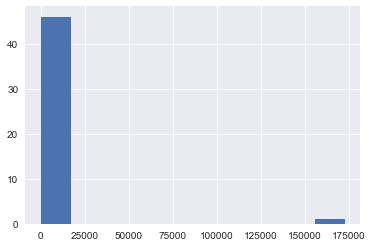

In [7]:
data.MetroTime.hist();

Похоже, есть интересное значение справа

In [8]:
data.MetroTime.max()

172800.0

In [9]:
172800.0/60/24

120.0

Возможно, кто-то действительно тратит 120 дней своей жизни на поездки на метро, но предположим, что человек все же ошибся и заменим значение на что-то более нейтральное и медианное

In [10]:
data.MetroTime[data.MetroTime==data.MetroTime.max()] = data.MetroTime.median()

(0, 161.6)

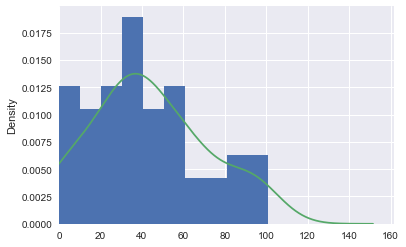

In [11]:
data.MetroTime.hist(normed=True, bins=10)
data.MetroTime.plot.kde()
plt.xlim(0)

### Заполнение пропусков
Если студент не указал время на метро, предположим, что он им и не пользуется, так что заполним пропуски нулями, а заодно создадим переменную - пользуется ли студент метро

In [12]:
data.MetroTime = data.MetroTime.fillna(0)

In [13]:
data['UseMetro'] = data.MetroTime != 0

In [14]:
data.UseMetro.value_counts()

True     43
False    13
Name: UseMetro, dtype: int64

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Star_wars2.svg/1200px-Star_wars2.svg.png)

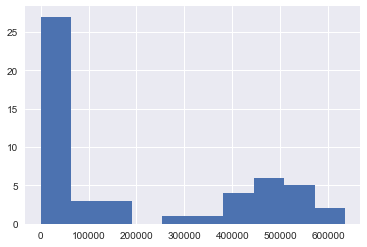

In [15]:
data.StarWars.hist(bins=10);

Снова предположим, что если что-то пропущено, это значит, что человек не смотрел величайшую космическую сагу и вообще как так можно жить

![](https://i.gifer.com/Bme8.gif)

In [16]:
data.StarWars.fillna(0, inplace=True)

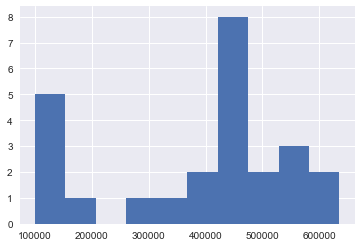

In [17]:
data.StarWars[data.StarWars>0].hist(bins=10)

Далее происходит немного магии и преобразований нашей переменной с перекодированием её в строку, заменой нулей на строку из шести нулей и разбиением одного столбца на шесть отдельных. Также не забываем дропнуть из исходного датасета закодированные переменные.

In [18]:
data.StarWars = data.StarWars.astype(int).astype(str)
data.StarWars = data.StarWars.replace('0', '000000')
data.StarWars = data.StarWars.apply(lambda row: [x for x in row])

StarWars = pd.DataFrame(data.StarWars.tolist())
StarWars.columns = ["SW_{}".format(i) for i in range(1, 7)]

data.drop(['StarWars'], axis=1, inplace=True)

In [19]:
StarWars.head()

,SW_1,SW_2,SW_3,SW_4,SW_5,SW_6
0,0,0,0,0,0,0
1,1,6,4,5,2,3
2,5,4,3,6,1,2
3,4,5,6,1,2,3
4,4,5,6,3,2,1


Вот здесь можно было бы добавить полученные датасет с эпизодами ЗВ в наш исходный датасет, но дальнейшая практика показала, что это слишком уж мощный признак, по которому сразу  студенты делятся на две группы - тех, кто смотрел ЗВ, и тех, кто не смотрел, а это не так интересно для  нашего мини-исследования, поэтому добавлять мы сейчас этот кусок не будем :3

In [20]:
#data = pd.concat([data, StarWars.astype(int)], axis=1)

## ExamScore

![](https://i.ytimg.com/vi/inY2_sZCw20/hqdefault.jpg)

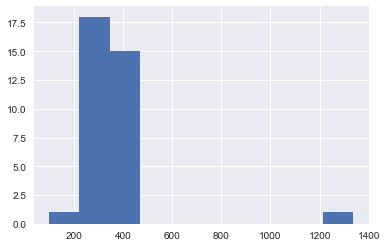

In [21]:
data.ExamScore.hist();

In [22]:
data.ExamScore.max()

1337.0

In [23]:
data[data.ExamScore==1337]

,Name,FavoriteSeries,MetroTime,ExamScore,HomeInternetSpeed,UseMetro
30,Агарков Максим Алексеевич,Уилфред,0.0,1337.0,плохо,False


Впечатляющий результат! Чуров был бы доволен. Но скорее всего единичка затесалась туда нечаянно, так что уберем лишнюю тысячу баллов

In [24]:
data.ExamScore[data.ExamScore==data.ExamScore.max()] = 337

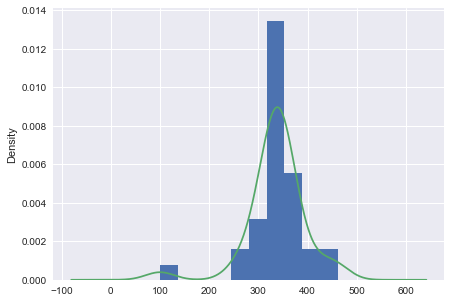

In [25]:
plt.figure(figsize=(7, 5))
data.ExamScore.hist(normed=True)
data.ExamScore.plot.kde();

Судя по равпределению, кто-то сдавал 3 экзамена, кто-то 4, кто-то указал всего 1, так что надо бы это дело привести к чему-то более-менее однородному, давайте сначала посчитаем, сколько человек сдавал экзаменов.

Для этого возьмем целый остаток от деления на $100$ и прибавим к нему $1$, если есть нецелый остаток от $100$. Например, если у человека 350 баллов, то первая часть нам даст $350//100 = 3$, а вторая $350%100=50$; $50 > 0 = 1 (True)$; итого $3 + 1 = 4$ экзамена

In [26]:
data['ExamQuantity'] = data.ExamScore//100 + (data.ExamScore%100 > 0).astype(int)
data['ExamQuantity'] = data['ExamQuantity'].fillna(0).astype(int)

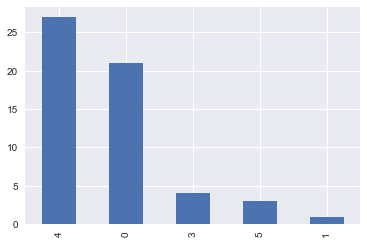

In [27]:
data.ExamQuantity.value_counts().plot.bar();

А теперь добавим переменную со средним баллом, потому что мы можем, и потому что это круто

In [28]:
data['AverageScore'] = data.ExamScore.div(data.ExamQuantity)

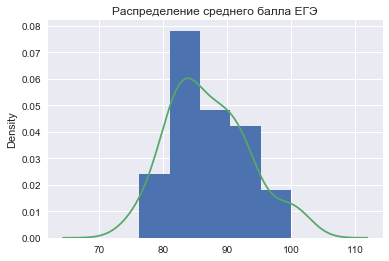

In [29]:
data.AverageScore.hist(bins=5, normed=True)
data.AverageScore.plot.kde()
plt.title("Распределение среднего балла ЕГЭ");

Теперь мы можем облегченно дропнуть наш изначальный ExamScore, так как у нас появились две новых переменных, его кодирующих. А заодно еще добавим переменную ScoreUnknown, чтобы отслеживать тех, кто ЕГЭ либо не сдавал, либо благополучно успел забыть свой результат

In [30]:
data.drop(['ExamScore'], axis=1, inplace=True)

In [31]:
data['ScoreUnknown'] = data.AverageScore.isnull()

In [32]:
data.ScoreUnknown.value_counts()

False    35
True     21
Name: ScoreUnknown, dtype: int64

Пропущенные значения снова заполним медианами, чтобы они нам не мешались

In [33]:
data.AverageScore = data.AverageScore.fillna(data.AverageScore.median())

In [34]:
data.head()

,Name,FavoriteSeries,MetroTime,HomeInternetSpeed,UseMetro,ExamQuantity,AverageScore,ScoreUnknown
0,Акчурина Анастасия Максимовна,"Друзья, Шерлок, Стыд, Рик и Морти, Игра престо...",15.0,NaN,True,3,94.00,False
1,Асадуллин Амир Искандерович,"Gravity Falls, South Park, Futurama, Star vs. ...",0.0,плохо,False,4,82.25,False
2,Болотина Елизавета Александровна,"Доктор хаус, Конец этого еххного мира, Оранжев...",30.0,хорошо,True,4,84.25,False
3,Борщенюк Александра Витальевна,"Черное зеркало, Как я встретил вашу маму, Спле...",40.0,средне,True,4,87.75,False
4,Веденеев Степан Васильевич,"Игра престолов, Теория большого взрыва",30.0,хорошо,True,3,100.00,False


## HomeInternetSpeed

![](https://i0.wp.com/www.developermemes.com/wp-content/uploads/2015/02/Chrome-Vs-Firefox-While-IE-Eats-Glue.jpg?fit=698%2C501)

In [35]:
data.HomeInternetSpeed.value_counts()

хорошо    19
средне    17
плохо      9
Name: HomeInternetSpeed, dtype: int64

Закодируем слова цифрами, здесь не нужно делать OHE так как мы заведомо предполагаем, что одна категория лучше (больше) другой и можем это передать при помощи циферок

In [36]:
data.HomeInternetSpeed = data.HomeInternetSpeed.map({'хорошо':1, "средне":0, "плохо":-1})

Снова запомним тех, про кого мы не знаем

In [37]:
data['InternetSpeedUnknown'] = data.HomeInternetSpeed.isnull()

И заполним пропуски нулями (категория средне)

In [38]:
data.HomeInternetSpeed = data.HomeInternetSpeed.fillna(0).astype(int)

In [39]:
data.head()

,Name,FavoriteSeries,MetroTime,HomeInternetSpeed,UseMetro,ExamQuantity,AverageScore,ScoreUnknown,InternetSpeedUnknown
0,Акчурина Анастасия Максимовна,"Друзья, Шерлок, Стыд, Рик и Морти, Игра престо...",15.0,0,True,3,94.00,False,True
1,Асадуллин Амир Искандерович,"Gravity Falls, South Park, Futurama, Star vs. ...",0.0,-1,False,4,82.25,False,False
2,Болотина Елизавета Александровна,"Доктор хаус, Конец этого еххного мира, Оранжев...",30.0,1,True,4,84.25,False,False
3,Борщенюк Александра Витальевна,"Черное зеркало, Как я встретил вашу маму, Спле...",40.0,0,True,4,87.75,False,False
4,Веденеев Степан Васильевич,"Игра престолов, Теория большого взрыва",30.0,1,True,3,100.00,False,False


## FavoriteSeries
Самое интересное и сложненькое

![](https://s3.amazonaws.com/dailybreak_images_prod/4c62fad1-004c-4cf5-8cb1-1b873ea4facb)

Для начала - переведем весь текст в нижний регистр

In [40]:
data.FavoriteSeries = data.FavoriteSeries.str.lower()

Теперь заполним все пропуски кодовым словом noseries

In [41]:
data.FavoriteSeries.fillna('noseries', inplace=True)

Теперь не особо хитрыми манимуляциями сначала разобьем каждую строку по запятой, чтобы  получить отдельные сериалы, а затем те названия сериалов, которые состоят из отдельных слова (рик и морти) склеим друг с другом через нижнее подчеркивание (рик\_и\_морти) и опять преобразуем в целую строку

In [42]:
data.FavoriteSeries_processed = data.FavoriteSeries.str.split(',')
print(data.FavoriteSeries_processed.head())

data.FavoriteSeries_processed = data.FavoriteSeries_processed.apply(
    lambda row: [x.strip().replace(' ', '_') for x in row])
print(data.FavoriteSeries_processed.head())

data.FavoriteSeries_processed = data.FavoriteSeries_processed.apply(lambda row: ",".join(row))
print(data.FavoriteSeries_processed.head())

0    [друзья,  шерлок,  стыд,  рик и морти,  игра п...
1    [gravity falls,  south park,  futurama,  star ...
2    [доктор хаус,  конец этого еххного мира,  оран...
3    [черное зеркало,  как я встретил вашу маму,  с...
4            [игра престолов,  теория большого взрыва]
Name: FavoriteSeries, dtype: object
0    [друзья, шерлок, стыд, рик_и_морти, игра_прест...
1    [gravity_falls, south_park, futurama, star_vs....
2    [доктор_хаус, конец_этого_еххного_мира, оранже...
3    [черное_зеркало, как_я_встретил_вашу_маму, спл...
4             [игра_престолов, теория_большого_взрыва]
Name: FavoriteSeries, dtype: object
0    друзья,шерлок,стыд,рик_и_морти,игра_престолов,...
1    gravity_falls,south_park,futurama,star_vs._the...
2    доктор_хаус,конец_этого_еххного_мира,оранжевый...
3    черное_зеркало,как_я_встретил_вашу_маму,сплетн...
4                игра_престолов,теория_большого_взрыва
Name: FavoriteSeries, dtype: object


А теперь мы будем считать, кто чего смотрел при помощи CountVectorizer - как он устроен посмотрим на доске

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [44]:
FavoriteSeries_processed = vectorizer.fit_transform(data.FavoriteSeries_processed)

In [45]:
FavoriteSeries_processed

<56x95 sparse matrix of type '<class 'numpy.int64'>'
	with 198 stored elements in Compressed Sparse Row format>

Не так уж много уникальных сериалов - всего 95, так что можно из разреженной матрицы перейти к датафрему

In [46]:
FavoriteSeries_processed = pd.DataFrame(FavoriteSeries_processed.toarray())
FavoriteSeries_processed.columns = vectorizer.get_feature_names()

In [47]:
FavoriteSeries_processed.head()

,13_причин_почему,2_девицы_на_мели,_the_forces_of_evil,adventure_time,big_little_lies,change,empire,futurama,girl_boss,gravity_falls,...,твин_пикс,теория_большого_взрыва,теория_лжи,уилфред,фарго,флэш,ходячие_мертвецы,хор,черное_зеркало,шерлок
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


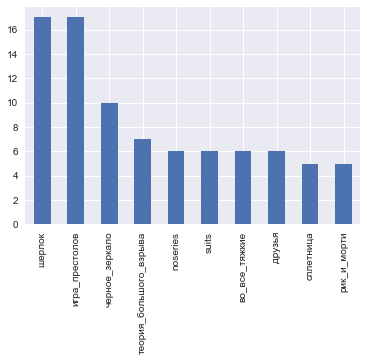

In [48]:
FavoriteSeries_processed.sum().sort_values(ascending=False).head(10).plot.bar();

Выделим отдельно топ-10 сериалов, которые смотрит большинство

In [49]:
top_ten_series = FavoriteSeries_processed.sum().sort_values(ascending=False).head(10).index

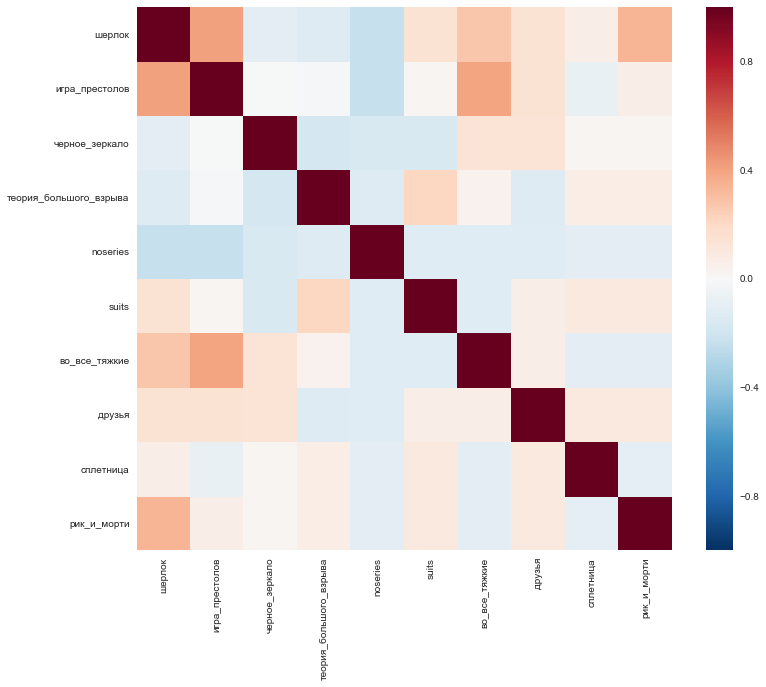

In [50]:
plt.figure(figsize = (12, 10))
sns.heatmap(FavoriteSeries_processed[top_ten_series].corr('spearman'));

Добавим этим топ-10 к датасету и выкинем изначальную переменную, которую мы закодировали

In [51]:
data = pd.concat([data, FavoriteSeries_processed[top_ten_series]], axis=1)

In [52]:
data['TotalSeriesWatched'] = FavoriteSeries_processed.sum(1)

In [53]:
data.head()

,Name,FavoriteSeries,MetroTime,HomeInternetSpeed,UseMetro,ExamQuantity,AverageScore,ScoreUnknown,InternetSpeedUnknown,шерлок,игра_престолов,черное_зеркало,теория_большого_взрыва,noseries,suits,во_все_тяжкие,друзья,сплетница,рик_и_морти,TotalSeriesWatched
0,Акчурина Анастасия Максимовна,"друзья, шерлок, стыд, рик и морти, игра престо...",15.0,0,True,3,94.00,False,True,1,1,0,0,0,0,0,1,0,1,7
1,Асадуллин Амир Искандерович,"gravity falls, south park, futurama, star vs. ...",0.0,-1,False,4,82.25,False,False,0,0,0,0,0,0,0,0,0,0,5
2,Болотина Елизавета Александровна,"доктор хаус, конец этого еххного мира, оранжев...",30.0,1,True,4,84.25,False,False,0,0,0,0,0,0,0,0,0,0,6
3,Борщенюк Александра Витальевна,"черное зеркало, как я встретил вашу маму, спле...",40.0,0,True,4,87.75,False,False,0,0,1,0,0,0,0,0,1,0,6
4,Веденеев Степан Васильевич,"игра престолов, теория большого взрыва",30.0,1,True,3,100.00,False,False,0,1,0,1,0,0,0,0,0,0,2


## NameLength
Напоследок, добавим длину имени в качестве признака и на этом успокоимся

In [54]:
data['NameLength'] = data.Name.apply(len)
data.set_index(data.Name, inplace=True)

In [55]:
data.drop(['Name', 'FavoriteSeries'], axis=1, inplace=True)

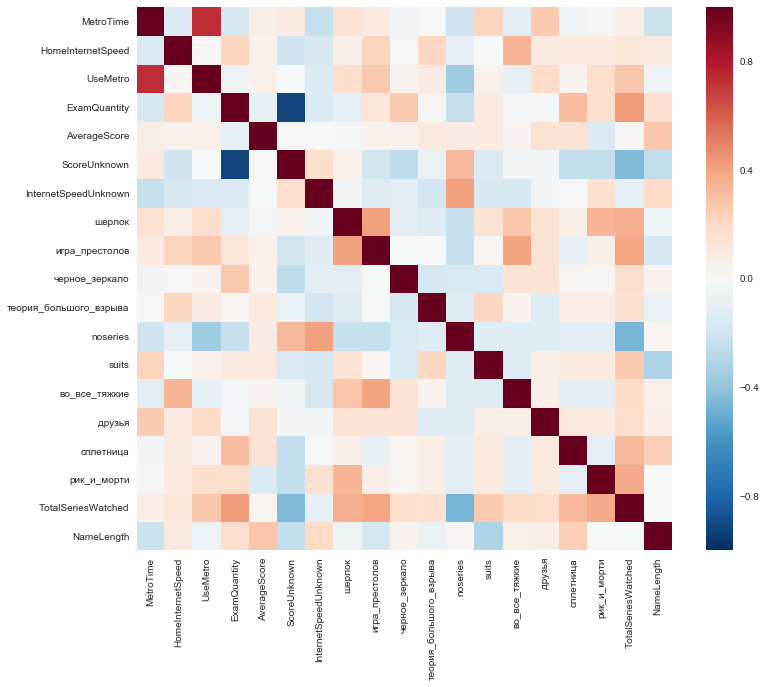

In [56]:
plt.figure(figsize = (12, 10))
sns.heatmap(data.corr('spearman'));

In [57]:
data.columns

Index(['MetroTime', 'HomeInternetSpeed', 'UseMetro', 'ExamQuantity',
       'AverageScore', 'ScoreUnknown', 'InternetSpeedUnknown', 'шерлок',
       'игра_престолов', 'черное_зеркало', 'теория_большого_взрыва',
       'noseries', 'suits', 'во_все_тяжкие', 'друзья', 'сплетница',
       'рик_и_морти', 'TotalSeriesWatched', 'NameLength'],
      dtype='object')

![](https://media.collegetimes.com/uploads/2015/03/its-done.gif)

## Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи. Перечисленные алгоритмы ни в коем случае не описывают данное множество полностью, но являются примерами самых популярных методов решения задачи кластеризации.


<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption>Примеры работы алгоритмов кластеризации из документации пакета scikit-learn</figcaption></figure>

### K-means

Алгоритм К-средних, наверное, самый популярный и простой алгоритм кластеризации и очень легко представляется в виде простого псевдокода:
1. Выбрать количество кластеров $k$, которое нам кажется оптимальным для наших данных.
2. Высыпать случайным образом в пространство наших данных $k$ точек (центроидов).
3. Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

Начнем мы с того, что отшкалируем наши непрерывные переменные, чтобы все они были в одном масштабе

In [58]:
from sklearn.preprocessing import StandardScaler

# преобразуем все признаки в числовые
X = data.copy()
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['MetroTime', 'AverageScore', 'NameLength', 'TotalSeriesWatched']] =\
scaler.fit_transform(X[['MetroTime', 'AverageScore', 'NameLength', 'TotalSeriesWatched']])

Для разнообразия можем снова посомтреть, как наши многомерные данные выглядят на двумерной плоскости

In [59]:
from sklearn.manifold import TSNE

In [60]:
%%time
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

CPU times: user 545 ms, sys: 69.9 ms, total: 615 ms
Wall time: 634 ms


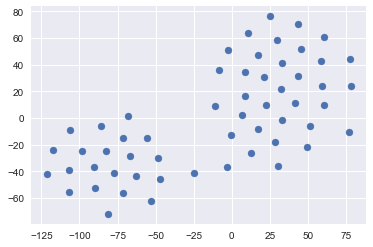

In [61]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1]);

Похоже, что-то разделить явно можно

## Выбор числа кластеров для kMeans

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.
$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". 

In [62]:
from sklearn.cluster import KMeans       # сама модель
from sklearn import metrics              # куда ж мы без метрик
from scipy.spatial.distance import cdist # функция для рассчета расстояний между парами точек

# будем искать оптимальное k
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

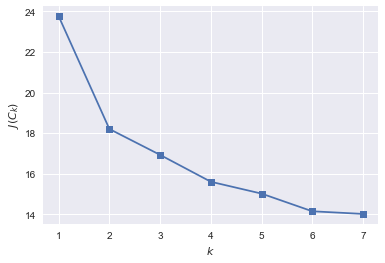

In [63]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Кажется, после двух кластеров наш функционал ошибки стал уменьшаться не так быстро

In [64]:
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Из модели мы можем вытаскивать также и лэйблы классов

In [65]:
kmeanModel.labels_

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0], dtype=int32)

In [66]:
X['clusterLabels'] = kmeanModel.labels_
X_scaled['clusterLabels'] = kmeanModel.labels_
X.clusterLabels.value_counts()

0    34
1    22
Name: clusterLabels, dtype: int64

Снова можем посмотреть на нашу двумерную репрезентацию

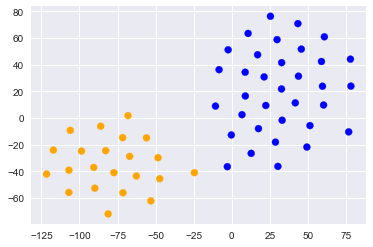

In [67]:
labels = list(kmeanModel.labels_)

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=X['clusterLabels'].map({0: 'blue', 1: 'orange'}));

Наконец, можем посмотреть, чем, в среднем, отличаются две группы

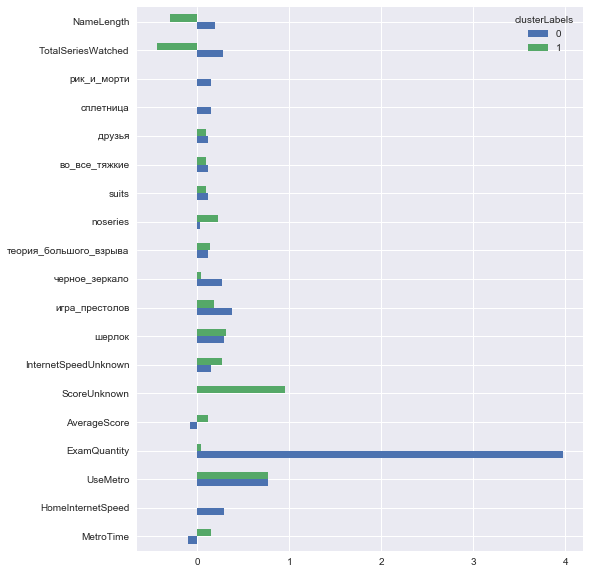

In [68]:
X_scaled.groupby('clusterLabels').mean().T.plot.barh(figsize=(8, 10));

In [69]:
X_scaled[['clusterLabels']]

,clusterLabels
Name,
Акчурина Анастасия Максимовна,0
Асадуллин Амир Искандерович,0
Болотина Елизавета Александровна,0
Борщенюк Александра Витальевна,0
Веденеев Степан Васильевич,0
Горбунова Анастасия Алексеевна,0
Даниелян Артем Гарикович,1
Даниелян Ованнес Каренович,1
Евсеев Владислав Юрьевич,1


# Агломеративная или иерархическая кластеризация

Наверное самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — агломеративная кластеризация. Интуиция у алгоритма очень простая: 
1. Начинаем с того, что высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

По итогам выполнения такого алгоритма можно построить замечательное дерево склеивания кластеров и глядя на него определить, на каком этапе нам было бы оптимальнее всего остановить алгоритм. Либо воспользоваться тем же правилом локтя, что и в k-means.

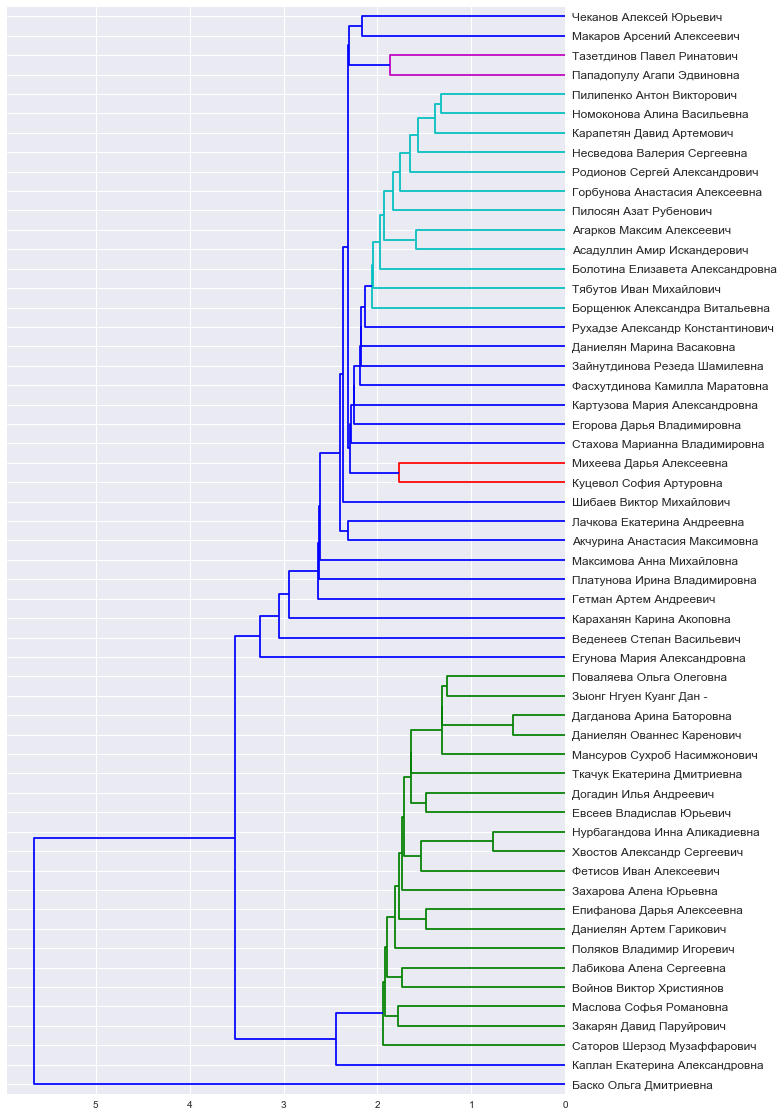

In [70]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(X_scaled) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 20))
dn = hierarchy.dendrogram(Z, color_threshold=2.1, labels=X.index,leaf_font_size=12., orientation='left')

![](https://i.gifer.com/7CXm.gif)

![](http://i0.kym-cdn.com/photos/images/newsfeed/000/707/322/fac.gif)